In [ ]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
to############### upload data
# Mount Google drive to load data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

path ='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/new_processed_data/test.csv'

text_data = pd.read_csv(path, sep=',')
print(text_data)

                    id  ... identity_hate
0     6d5688fab66073c6  ...             1
1     64fc056641dba716  ...             0
2     ff5c60747f023cbd  ...             0
3     d4e23c86f5b1d708  ...             1
4     9a9dc24ba68e7597  ...             0
...                ...  ...           ...
3022  0cf27594013bb708  ...             0
3023  c04d00a14a202a94  ...             0
3024  b00ced343a0c5d8b  ...             1
3025  6ae73417bb0c7b61  ...             0
3026  fcda70fcb02196ce  ...             1

[3027 rows x 8 columns]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext import data
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import argparse
import os
import datetime, time

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim=100):
        super(CNN_LSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.hidden_dim = hidden_dim

        self.conv1 = nn.Conv2d(1, 100,kernel_size=(2,embedding_dim)) #in_channels, out_chanels, kernel_size
        
        
        self.lstm1 = nn.LSTM(embedding_dim,hidden_dim)
        target_size = 6
        self.fc1 = nn.Linear(hidden_dim, target_size)

    def forward(self, x, lengths):
    #   embeds = self.word_embeddings(sentence)
    #     lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
    #     tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    #     tag_scores = F.log_softmax(tag_space, dim=1)
    #     return tag_scores
        
        x = self.embedding(x)
        # print('x.shape',x.shape)

        x = x.unsqueeze(0)
        # print('x = x.unsqueeze(0)',x.shape)
        x = x.transpose(1,2) # swaps 2nd and 3rd dimension
        # print('x = x.transpose(1,2)',x.shape)
        x = x.transpose(0,1) # swaps 1st and 2nd dimension, now it has the correct input (n_samples,channels, height, width)
        # print('x = x.transpose(0,1)',x.shape)
        x1 = F.relu(self.conv1(x)) 
        # print('x1 = F.relu(self.conv1(x))',x1.shape)
        
        x1 = x1.squeeze(3)
        # print('x1 = x1.squeeze(3)',x1.shape)
        pool1 = nn.MaxPool1d(x1.size(2), 1) #maxpool
        
        x = pool1(x1)
        # print('pool1 = nn.MaxPool1d(x1.size(2), 1)',x.shape)
        x = x.squeeze(2)
        x = x.unsqueeze(0)
        # print('x = x.squeeze(2)',x.shape)


        #  pack the word embeddings in the batch together and 
        # run the RNN on this object
        # x = pack_padded_sequence(x,lengths) 
        # print('x.shape',x.shape)
        x,(h,c) = self.lstm1(x)
        # print('x.shape',x.shape)
        # print('h.shape',h.shape)
        # print('len(h)',len(h))
        # print('(x.view(len(lengths),-1)).shape',(x.view(len(lengths),-1)).shape)
        h_result = self.fc1(h.squeeze(0))
        # print('no sigmoid',h_result)
        # h_result = F.log_softmax(tag_space, dim=1) --> change to this with multiple cat
        h_result = torch.sigmoid(h_result)
        # print('sigmoid',h_result)
        

        return h_result

Shape of Vocab: torch.Size([32883, 100])
correct 2490
accuracy 0.10285006195786865
[1] train loss: 0.612, train acc: 0.103, validation loss: 0.597, validation acc: 0.117 
correct 2626
accuracy 0.10846757538207352
[2] train loss: 0.599, train acc: 0.108, validation loss: 0.601, validation acc: 0.128 
correct 3594
accuracy 0.14845105328376704
[3] train loss: 0.595, train acc: 0.148, validation loss: 0.586, validation acc: 0.192 
correct 4676
accuracy 0.19314332920280874
[4] train loss: 0.586, train acc: 0.193, validation loss: 0.585, validation acc: 0.192 
correct 4744
accuracy 0.1959520859149112
[5] train loss: 0.584, train acc: 0.196, validation loss: 0.582, validation acc: 0.202 
correct 4780
accuracy 0.19743907476249484
[6] train loss: 0.583, train acc: 0.197, validation loss: 0.585, validation acc: 0.195 
correct 4870
accuracy 0.20115654688145396
[7] train loss: 0.583, train acc: 0.201, validation loss: 0.582, validation acc: 0.203 
correct 4918
accuracy 0.20313919867823213
[8] trai

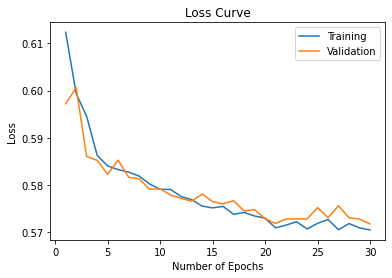

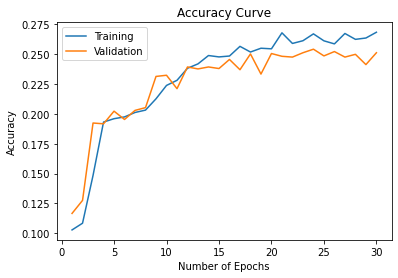

In [ ]:
trainRNN_R(seed = 0, batch_size = 64, learning_rate = 0.01, epochs = 30, model = CNN_LSTM, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50)

In [ ]:
def trainRNN_R(seed = 0, batch_size = 64, learning_rate = 0.001, epochs = 5, model = CNN_LSTM, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50):


  torch.manual_seed(seed)

  COMMENT_TEXT    = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
  TOXIC           = data.Field(sequential=False, use_vocab=False)
  SEVERE_TOXIC    = data.Field(sequential=False, use_vocab=False)
  OBSCENE         = data.Field(sequential=False, use_vocab=False)
  THREAT          = data.Field(sequential=False, use_vocab=False)
  INSULT          = data.Field(sequential=False, use_vocab=False)
  IDENTITY_HATE   = data.Field(sequential=False, use_vocab=False)

  train_data, val_data, test_data = data.TabularDataset.splits(
          path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/new_processed_data/', train='train.csv',
          validation='valid.csv', test='test.csv', format='csv',
          skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])

          # path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/multi_loose_large_data/', train='train.csv',
          # validation='valid.csv', test='test.csv', format='csv',
          # skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])

  train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size, batch_size),sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)

  COMMENT_TEXT.build_vocab(train_data, val_data, test_data)

  COMMENT_TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
  vocab = COMMENT_TEXT.vocab

  print("Shape of Vocab:",COMMENT_TEXT.vocab.vectors.shape)   


  model = model(emb_dim, vocab)
  # model = model(vocab)

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  lossCount = []
  valLossCount = []
  accCount = []
  valAccCount = []
  testLossCount = []
  testAccCount = []
  epochCount = []
  
  for epoch in range(epochs):  # loop over the dataset multiple times
      correct = 0
      total = 0
      runningLoss = 0.0
      numberOfBatches = 0
      valCorrect = 0
      valRunningLoss = 0.0
      valNumberOfBatches = 0
      valTotal = 0
      for i, batch in enumerate(train_iter, 0):
          # get the set of text sentences in the batch and length of the sentence sequences
          batch_input, batch_input_length = batch.text
          labels = []
          for i in range(len(batch.toxic)):
             labels += [[float(batch.toxic[i]), float(batch.severe_toxic[i]), float(batch.obscene[i]), float(batch.threat[i]),float(batch.insult[i]), float(batch.identity_hate[i])]]
          # print('(labels)',labels)
          labels=torch.FloatTensor(labels)
          # print('labels tensor size',labels.shape)
          # print('text tensor size',batch_input.shape)
          # labels = batch.toxic.float()    
          # print(labels)
      
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(batch_input, batch_input_length)
          loss = criterion(outputs, labels)
          # print('loss',loss)
          loss.backward()
          optimizer.step()   
          # print('labels',labels)      
          # print('outputs',outputs) 

          temp = ((outputs > 0.5).squeeze().long() == labels)
          # print('temp',temp)
          
          # correct = 0
          for i in temp:
            if torch.equal(i, torch.BoolTensor([True, True, True, True, True, True])):
              correct += 1
              # print('correct temp',i)

          # # evaluate training accuracy
          # with torch.no_grad():
          #   outputs = (outputs>0.5).float()
          #   correct += (outputs == labels).sum().item()
          
          # add training loss
          runningLoss += loss.item()

          # count the number of batches and samples
          numberOfBatches += 1
          total += labels.size(0)
          # print('total',total)



      # evaluate validation loss and 
      with torch.no_grad():
        for batch in val_iter:
          batch_input, batch_input_length = batch.text
          
          # labels = batch.toxic.float()   
          labels = []
          for i in range(len(batch.toxic)):
             labels += [[float(batch.toxic[i]), float(batch.severe_toxic[i]), float(batch.obscene[i]), float(batch.threat[i]),float(batch.insult[i]), float(batch.identity_hate[i])]]
          # print('(labels)',labels)
          labels=torch.FloatTensor(labels)

          outputs = model(batch_input, batch_input_length)
          loss = criterion(outputs, labels)
          valRunningLoss += loss.item()

          temp = ((outputs > 0.5).squeeze().long() == torch.FloatTensor(labels))
          # valCorrect = 0
          for i in temp:
            if torch.equal(i, torch.BoolTensor([True, True, True, True, True, True])):
              valCorrect += 1

          # outputs = (outputs>0.5).float()
          # valCorrect += (outputs == labels).sum().item()
          valTotal += labels.size(0)
          valNumberOfBatches += 1


      runningLoss = runningLoss/numberOfBatches
      print('correct',correct)
      correct = correct/total
      print('accuracy',correct)
      valRunningLoss = valRunningLoss/valNumberOfBatches
      valCorrect = valCorrect/valTotal
      # print statistics for every epoch)
      print('[%d] train loss: %.3f, train acc: %.3f, validation loss: %.3f, validation acc: %.3f ' %
                    (epoch + 1, runningLoss, correct, valRunningLoss, valCorrect))
      lossCount += [runningLoss]
      accCount += [correct]
      epochCount += [epoch+1]
      valLossCount += [valRunningLoss]
      valAccCount += [valCorrect]

      

  testCorrect = 0
  testRunningLoss = 0.0
  testNumberOfBatches = 0
  testTotal = 0
  with torch.no_grad():
        for batch in test_iter:
          batch_input, batch_input_length = batch.text

          # labels = batch.toxic.float()   
          labels = []
          for i in range(len(batch.toxic)):
             labels += [[float(batch.toxic[i]), float(batch.severe_toxic[i]), float(batch.obscene[i]), float(batch.threat[i]),float(batch.insult[i]), float(batch.identity_hate[i])]]
          # print('(labels)',labels)
          labels=torch.FloatTensor(labels)

          outputs = model(batch_input, batch_input_length)
          loss = criterion(outputs, labels)
          testRunningLoss += loss.item()

          temp = ((outputs > 0.5).squeeze().long() == torch.FloatTensor(labels))
          # testCorrect = 0
          for i in temp:
            if torch.equal(i, torch.BoolTensor([True, True, True, True, True, True])):
              testCorrect += 1

          # outputs = (outputs>0.5).float()
          # testCorrect += (outputs == labels).sum().item()
          testTotal += labels.size(0)
          testNumberOfBatches += 1
        testRunningLoss = testRunningLoss/testNumberOfBatches
        testLossCount += [testRunningLoss]
        testAccCount += [testCorrect]
  print('Finished Training. Test accuracy is %.3f and loss is %.3f' % (testCorrect/testTotal, testRunningLoss))

  #plot
  plt.title("Loss Curve")
  plt.plot(epochCount, lossCount, label="Training")
  plt.plot(epochCount, valLossCount, label="Validation")
  # plt.plot(epochCount, testLossCount, label="Testing")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()


  plt.title("Accuracy Curve")
  plt.plot(epochCount, accCount, label = "Training")
  plt.plot(epochCount, valAccCount, label = "Validation")
  # plt.plot(epochCount, testAccCount, label="Testing")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  torch.save(model,'model_rnn.pt')